## Import Libraries and Data

In [54]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/PhD_MasterDataset_OT_initial.csv', firstRow=36, lastRow=42)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_191222_S37-42_run1.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)

## Analyse water addition

In [55]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=3)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=48s and ended at t=424s; mass=43.4459g
This equals a volume of 43.533m; expected was 43.469mL; error is 0.147%


## Analyise surfactants

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.0005625 g/s^2


<IPython.core.display.Javascript object>


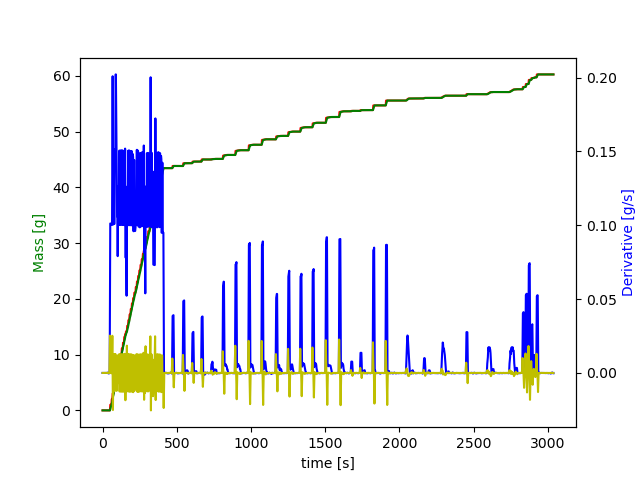

Addition of 0.387g Texapon SB 3 KC detected from 466s to 486s - expected volume = 0.514mL and actual volume = 0.346mL (resulting error is 32.713%)
Addition of 0.51g Texapon SB 3 KC detected from 538s to 576s - expected volume = 0.514mL and actual volume = 0.456mL (resulting error is 11.357%)
Addition of 0.277g Texapon SB 3 KC detected from 600s to 620s - expected volume = 0.268mL and actual volume = 0.247mL (resulting error is 7.6%)
Addition of 0.371g Texapon SB 3 KC detected from 662s to 686s - expected volume = 0.361mL and actual volume = 0.335mL (resulting error is 7.125%)
Addition of 0.108g Plantacare 818 detected from 728s to 772s - expected volume = 0.102mL and actual volume = 0.1mL (resulting error is 1.455%)
Addition of 0.713g Plantacare 818 detected from 806s to 848s - expected volume = 0.792mL and actual volume = 0.657mL (resulting error is 17.081%)
Addition of 0.855g Plantacare 818 detected from 890s to 934s - expected volume = 0.792mL and actual volume = 0.787mL (resulting 

In [56]:
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant',steps=steps,start_idx=t1,show=True)

## Analyse polyelectrolytes

Peak threshold for 1st derivative = 0.00109375 g/s and for 2nd derivative = 0.0004921875 g/s^2


<IPython.core.display.Javascript object>


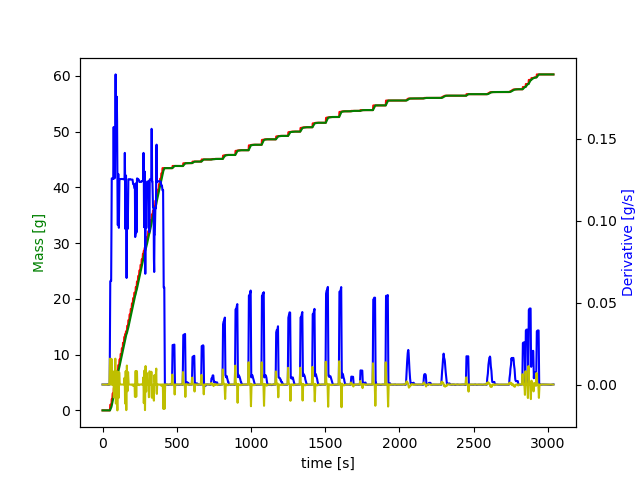

Addition of 0.359g Luviquat Excellence detected from 2042s to 2080s - expected volume = 0.365mL and actual volume = 0.328mL (resulting error is 10.187%)
Addition of 0.098g Luviquat Excellence detected from 2160s to 2186s - expected volume = 0.091mL and actual volume = 0.089mL (resulting error is 1.938%)
Addition of 0.393g Luviquat Excellence detected from 2280s to 2324s - expected volume = 0.362mL and actual volume = 0.356mL (resulting error is 1.844%)
Addition of 0.274g Dehyquart CC6 detected from 2446s to 2472s - expected volume = 0.381mL and actual volume = 0.261mL (resulting error is 31.562%)
Addition of 0.393g Dehyquart CC7 Benz detected from 2588s to 2644s - expected volume = 0.394mL and actual volume = 0.388mL (resulting error is 1.656%)
Addition of 0.505g Dehyquart CC7 Benz detected from 2738s to 2804s - expected volume = 0.491mL and actual volume = 0.496mL (resulting error is 0.975%)


In [57]:
t3 = massProfile.analyseIngredients(avg_window=8, bl_mult=7, mergeSens=8, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

## Analyse Thickeners

Peak threshold for 1st derivative = 0.01575 g/s and for 2nd derivative = 0.006187499999999999 g/s^2


<IPython.core.display.Javascript object>


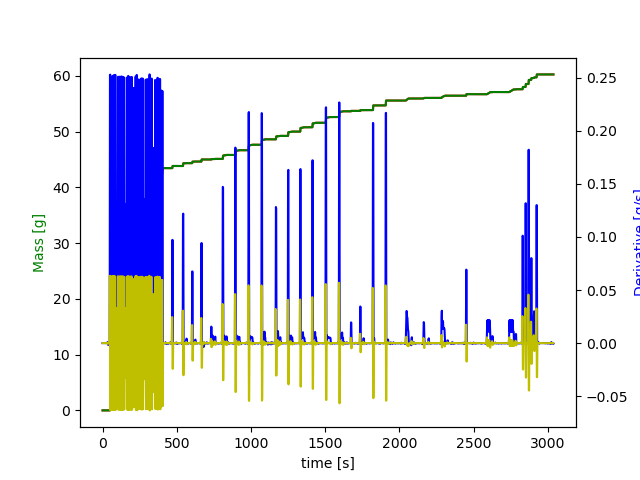

Addition of 0.409g Arlypon F detected from 2826s to 2838s - expected volume = 0.46mL and actual volume = 0.47mL (resulting error is 2.25%)
Addition of 0.536g Arlypon F detected from 2846s to 2858s - expected volume = 0.573mL and actual volume = 0.615mL (resulting error is 7.2%)
Addition of 0.742g Arlypon F detected from 2866s to 2878s - expected volume = 0.8mL and actual volume = 0.848mL (resulting error is 6.0%)
Addition of 0.328g Arlypon F detected from 2884s to 2896s - expected volume = 0.341mL and actual volume = 0.373mL (resulting error is 9.167%)
Addition of 0.121g Arlypon F detected from 2902s to 2914s - expected volume = 0.113mL and actual volume = 0.137mL (resulting error is 21.0%)
Addition of 0.524g Arlypon F detected from 2920s to 2932s - expected volume = 0.574mL and actual volume = 0.601mL (resulting error is 4.8%)


In [58]:
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=9, mergeSens=2, specType='thickener',steps=steps,start_idx=t3,show=True)

## Consolidate results and create output

In [59]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_S37-S42_run1.csv', index=False)
actualMassFractions

,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
36,37.0,0.000000,0.0,0.0,1.071245,21.532622,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,3.550229,0.00000,0.000000,0.0,4.041876,0.0
37,38.0,0.000000,0.0,0.0,15.602634,7.970986,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.975849,0.00000,0.000000,0.0,5.333893,0.0
38,39.0,0.000000,0.0,0.0,0.000000,20.248819,0.0,0.0,0.0,0.0,0.0,0.738944,0.0,3.852958,0.00000,0.000000,0.0,7.281489,0.0
39,40.0,9.079699,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.544339,0.0,0.000000,0.00000,3.983634,0.0,3.316531,0.0
40,41.0,2.742113,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,17.093690,0.0,0.000000,0.00000,4.994315,0.0,1.196954,0.0
41,42.0,3.686271,0.0,0.0,19.466290,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,2.71633,0.000000,0.0,5.199478,0.0
